In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
ed = tfp.edward2
import sys
sys.path.append("../")
from future_features import tape
import numpy as np
from plot_utils import plot_source_distributions, plot_ifa_parameters_and_ppc
%load_ext autoreload
%autoreload 2

In [2]:
from testsuite import MAP_model, neg_log_lik

/home/rabo/anaconda3/envs/tfp/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/rabo/anaconda3/envs/tfp/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/rabo/anaconda3/envs/tfp/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/rabo/anaconda3/envs/tfp/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/rabo/anaconda3/envs/tfp/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds

In [3]:
from tfpmodels import independentFactorAnalysis, centeredMarginalizedIndependentFactorAnalysis
from tfpmodels import centeredIndependentFactorAnalysisTest, centeredMarginalizedIndependentFactorAnalysisTest
from mapper import Mapper

In [4]:
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import FastICA, PCA

In [5]:
sess = tf.InteractiveSession()

In [16]:
n_components_in_mixture = 5
n_sources = 2
n_features = 2
n_observations = 1000

In [17]:
ifa_data = Mapper(centeredMarginalizedIndependentFactorAnalysis, 'ifa2', ['data'], n_observations=n_observations, n_components_in_mixture=n_components_in_mixture, n_features=n_features, n_sources=n_sources, mixture_component_var_concentration=.1*3, mixture_component_var_rate=1.*3,data_var_concentration=.1*3,data_var_rate=10.*3)
ifa_model = Mapper(centeredMarginalizedIndependentFactorAnalysis, 'ifa2', ['data'], n_observations=n_observations, n_components_in_mixture=n_components_in_mixture, n_features=n_features, n_sources=n_sources, mixture_component_var_concentration=.1*1, mixture_component_var_rate=1.*1,data_var_concentration=.1*2,data_var_rate=10.*4)

In [18]:
generated = sess.run(ifa_data.tape)

In [19]:
fica = FastICA(n_components=n_sources).fit(generated['data']).mixing_.T
fica = np.concatenate([fica,np.random.randn(n_sources-n_features,n_features)],axis=0)

#loss, train_op = ifa_model.adam_optimizer(data=generated['data'], learning_rate=0.001)
loss, opt = ifa_model.bfgs_optimizer(data=generated['data'])
#loss, opt = ifa.cg_optimizer(data=generated['data'])

init_ops = [tf.global_variables_initializer()]
# Initialize in true parameters, as a sanity check
#true_parameters = dict(generated)
#true_parameters.pop('data')
#init_ops.append(ifa_model.assigner(**true_parameters))

# FastICA, large SNR, uniformish mixing weight initialization
init_ops.append(tf.assign(ifa_model.unconstrained_variables['factor_loadings'], fica,name='initialize_directions'))
init_ops.append(tf.assign(ifa_model.unconstrained_variables['mixture_component_var'], 10*generated['data'].var()*np.random.rand(n_sources,n_components_in_mixture),name='initialize_signal_variance'))
init_ops.append(tf.assign(ifa_model.unconstrained_variables['data_var'], 1e-3*np.ones(ifa_model.unconstrained_variables['data_var'].shape),name='initialize_noise_variance'))
init_ops.append(tf.assign(ifa_model.unconstrained_variables['mixture_weights'], np.ones(ifa_model.unconstrained_variables['mixture_weights'].shape)/n_components_in_mixture,name='initialize_noise_variance'))

#initialized_parameters = sess.run(ifa_model.variables)
#initialized_parameters.pop('sources')
#train_nll_init = neg_log_lik(initialized_parameters,centeredIndependentFactorAnalysisTest,generated['data'])
#sess.run(tf.assign(ifa_model.unconstrained_variables['sources'], 2*np.ones(ifa.variable_shapes['sources'])))

accparams = []
learning_curve = []
def accumulate_parameters_and_loss(estimated_parameters, loss):
    accparams.append(estimated_parameters)
    learning_curve.append(loss)
sess.run([init_ops])
print(sess.run(ifa_model.map_neg_log_joint_fn(data=generated['data'])))
opt.minimize(loss_callback=accumulate_parameters_and_loss,fetches=[ifa_model.variables, loss])

2742.886
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -1785.625488
  Number of iterations: 53
  Number of functions evaluations: 81


# ADAM training
t = []
num_epochs = 20000
sess.run(init_ops)
for i in range(num_epochs):
    sess.run(train_op)
    if i % 5 == 0:
        current_loss = sess.run(loss)
        t.append(current_loss)
plt.plot(np.arange(num_epochs,step=5)*5,t)

variables_after_first_opt_run = ifa_model.variables

loss, train_op = ifa_model.adam_optimizer(data=generated['data'], learning_rate=0.0001)

# ADAM training
t = []
num_epochs = 20000
sess.run(tf.global_variables_initializer())
sess.run(ifa_model.assigner(**variables_after_first_opt_run))
for i in range(num_epochs):
    sess.run(train_op)
    if i % 5 == 0:
        current_loss = sess.run(loss)
        t.append(current_loss)
plt.plot(np.arange(num_epochs,step=5)*5,t)

plot_ifa_parameters_and_ppc(sess.run(ifa_model.variables), generated, sess)

In [20]:
learning_curve[0]

2742.886

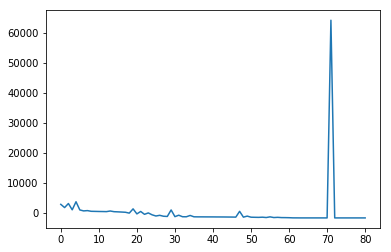

In [21]:
plt.plot(learning_curve)
#plt.ylim([-400000,400000])

In [22]:
testmodel = centeredMarginalizedIndependentFactorAnalysisTest(n_observations=n_observations, **ifa_model.variables)

[-4, 4, -4, 4]

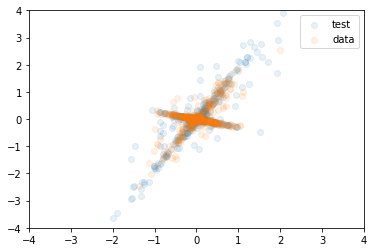

In [23]:
plt.scatter(*sess.run(testmodel).T,alpha=0.1,label='test')
plt.scatter(*generated['data'].T,alpha=0.1,label='data')
plt.legend()
plt.axis([-4,4,-4,4])